In [129]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

In [2]:
def preprocess_data(df, dropna=True, drop_columns=[]):
    if dropna:
        df = df.dropna()
    df = pd.get_dummies(df, drop_first=True)
    df = df.drop(columns=drop_columns)
    return df

def create_pipeline(estimator):
    steps = []
    steps.append(('scaler', StandardScaler()))
    steps.append(('estimator', estimator))
    pipeline = Pipeline(steps)
    return pipeline

def perform_grid_search(X_train, y_train, estimator, param_grid, cv_strategy, detailed_results_file):
    pipeline = create_pipeline(estimator)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_strategy, scoring='f1', n_jobs=-1, return_train_score=False)
    # grid_search = RandomizedSearchCV(pipeline, param_grid, cv=cv_strategy, scoring='f1', n_jobs=-1, return_train_score=False)
    grid_search.fit(X_train, y_train)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    # # Save the summary results to a CSV file
    # summary_results = results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    # summary_results.to_csv(summary_results_file, index=False)
    
    # Extract only the detailed results for the best parameter set
    columns_to_keep = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    columns_to_keep.extend([key for key in grid_search.cv_results_ if key.startswith('split')])
    results_filtered = results[columns_to_keep]
    
    results_filtered.to_csv(detailed_results_file, index=False)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions)
    return f1


param_grid_rfc = {
    'estimator__n_estimators': [100, 200, 300, 500, 1000],  # Number of trees in the forest
    'estimator__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'estimator__max_depth': [10, 20, 30, 40, 50, None],  # Maximum number of levels in tree
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'estimator__criterion': ['gini', 'entropy', 'log_loss'] # Method of selecting samples for training each tree
}

param_grid_lda = {
    # 'estimator__solver': ['svd', 'lsqr', 'eigen'],
    # 'estimator__n_components': [1, 2, 3, ...], # Uncomment if dimensionality reduction is needed
    # Shrinkage can only be used with the 'lsqr' and 'eigen' solvers
    'estimator__shrinkage': [None, 'auto', 0.99, 0.8, 0.6, 0.4, 0.2, 0.01]  # or a list np.linspace(0, 1, num=10)
}

param_grid_qda = {
    'estimator__reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Regularization parameter
}

param_grid_lr = [
    {'estimator__C': [0.01, 0.1, 1, 10, 100], 'estimator__solver': ['newton-cg', 'lbfgs', 'sag'], 'estimator__penalty': ['l2', 'none'], 'estimator__max_iter': [100, 200, 300]},
    {'estimator__C': [0.01, 0.1, 1, 10, 100], 'estimator__solver': ['liblinear'], 'estimator__penalty': ['l1', 'l2'], 'estimator__max_iter': [100, 200, 300]},
    {'estimator__C': [0.01, 0.1, 1, 10, 100], 'estimator__solver': ['saga'], 'estimator__penalty': ['l1', 'l2', 'elasticnet', 'none'], 'estimator__max_iter': [100, 200, 300]}
]

param_grid_dtr = {
    'estimator__max_depth': [None, 10, 20, 30, 40, 50],
    'estimator__min_samples_split': [2, 5, 10, 20],
    'estimator__min_samples_leaf': [1, 2, 4, 10],
    'estimator__max_features': ['auto', 'sqrt', 'log2', None],
    'estimator__criterion': ['gini', 'entropy']
}

param_grid_knn = {
    'estimator__n_neighbors': [3, 5, 7, 10, 15],
    'estimator__weights': ['uniform', 'distance'],
    # 'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'estimator__p': [1, 2, 3]  # Typically, 1 (Manhattan) or 2 (Euclidean) are used, but you can explore others
}


# Define your estimators and their parameter grids
estimators_and_parameters = {
    'LDA': (LDA(), param_grid_lda),
    'QDA': (QDA(), param_grid_qda),
    'LR': (LogisticRegression(), param_grid_lr),
    'DTR': (DecisionTreeClassifier(), param_grid_dtr),
    'KNN': (KNeighborsClassifier(), param_grid_knn),
    # 'SVM': (SVC(), param_grid_svm),
    'RFC': (RandomForestClassifier(), param_grid_rfc)
}

df = pd.read_csv('data_preprocessed.csv')
df_processed = preprocess_data(df, drop_columns=['relationship_Wife'])

# Split dataset into training and test data
X = df_processed.drop('income_>50K', axis=1)
y = df_processed['income_>50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define the cross-validation strategy
cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Search for the best model and parameters for each estimator
#best_models = {}
#best_parameters = {}
#for name, (estimator, param_grid) in estimators_and_parameters.items():
#    detailed_results_file = f'{name}_grid_search_detailed.csv'
#    best_model, best_params, best_score = perform_grid_search(
#        X_train, y_train, estimator, param_grid, cv_strategy, detailed_results_file)
#    best_models[name] = best_model
#    best_parameters[name] = best_params
#    print(f"Best F1 score for {name}: {best_score}")
#    print(f"Best parameters for {name}: {best_params}")



In [5]:

def load_and_display_top_params(model_name, scaler):
    # Construct the file name based on the provided model name
    file_name = f"{scaler}/{model_name}_grid_search_detailed.csv"
    
    # Load the data from CSV file
    results = pd.read_csv(file_name)
    
    # Drop rows with NaN values
    results.dropna(inplace=True)
    
    # Sort the results by the rank of the test scores
    results_sorted = results.sort_values(by='rank_test_score')
    
    # Extract the top three sets of parameters
    top_three_params = results_sorted.head(3)
    
    # Display the top three best sets of parameters
    print("Top three best sets of parameters:")
    for index, row in top_three_params.iterrows():
       # print(f"Rank {row['rank_test_score']}: {row['params']}, Mean Score: {row['mean_test_score']}, Std Dev: {row['std_test_score']}")
        pass
    return top_three_params

def get_cv_results_for_best_params(model_name, scaler):
    # Load the data and get the top three best parameter sets
    top_params = load_and_display_top_params(model_name, scaler)
    
    # Extract the best parameter set (the first row in the sorted dataframe)
    best_params_row = top_params.iloc[0]
    
    # Get all columns that contain individual CV results
    cv_score_columns = [col for col in best_params_row.index if col.startswith('split')]
    
    # Extract these scores
    cv_scores = best_params_row[cv_score_columns]
    
    import ast
    best_params_dict = ast.literal_eval(best_params_row['params'])
    

    return cv_scores.to_list(), best_params_dict

cv_results_min_max={}
cv_results_standard={}
best_params_min_max={}
best_params_standard={}
for name in estimators_and_parameters.keys():
    print(name)
    cv_results_min_max[name], best_params_min_max[name] = get_cv_results_for_best_params(name, scaler='MinMaxResults')
    cv_results_standard[name], best_params_standard[name] = get_cv_results_for_best_params(name, scaler='ScalerResults')
    print()


LDA
Top three best sets of parameters:
Top three best sets of parameters:

QDA
Top three best sets of parameters:
Top three best sets of parameters:

LR
Top three best sets of parameters:
Top three best sets of parameters:

DTR
Top three best sets of parameters:
Top three best sets of parameters:

KNN
Top three best sets of parameters:
Top three best sets of parameters:

RFC
Top three best sets of parameters:
Top three best sets of parameters:



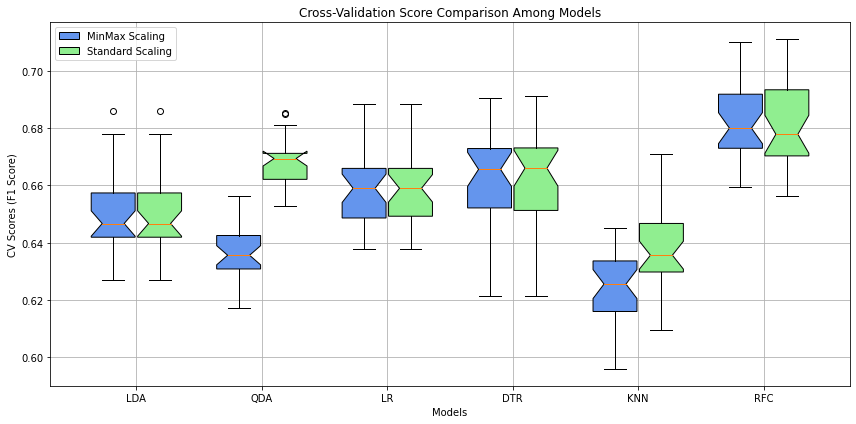

In [41]:
import matplotlib.pyplot as plt

def plot_cv_results(cv_results_min_max, cv_results_standard):
    fig, ax = plt.subplots(figsize=(12, 6))
    model_names = list(cv_results_min_max.keys())
    # Prepare data for plotting
    data_min_max = [cv_results_min_max[model] for model in model_names]
    data_standard = [cv_results_standard[model] for model in model_names]
    n_models = len(model_names)
    r = np.arange(n_models)
    width = 0.35
    

    # Create boxplots for each scaling method
    bplot1 = ax.boxplot(data_min_max, positions=r-width/2-0.01, widths=width,
                        patch_artist=True, boxprops=dict(facecolor='cornflowerblue'),
                        notch=True, labels=model_names)

    bplot2 = ax.boxplot(data_standard, positions=r+width/2+0.01, widths=width,
                        patch_artist=True, boxprops=dict(facecolor='lightgreen'),
                        notch=True, labels=[name + '\nStandard' for name in model_names])

    # Add title and labels
    ax.set_title('Cross-Validation Score Comparison Among Models')
    ax.set_ylabel('CV Scores (F1 Score)')
    ax.set_xlabel('Models')

    # Customize x-axis labels
    plt.xticks([x  for x in r], model_names)

    # Adding a custom legend
    ax.legend([bplot1["boxes"][0], bplot2["boxes"][0]], ['MinMax Scaling', 'Standard Scaling'])

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig('plots/cv_scaling_boxplots.png')
    plt.show()


plot_cv_results(cv_results_min_max, cv_results_standard)


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_confusion_metrics(y_test, y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    
    TP = np.sum((y_test == 1) & (y_pred == 1))
    
    FP = np.sum((y_test == 0) & (y_pred == 1))
    
    TN = np.sum((y_test == 0) & (y_pred == 0))
    
    FN = np.sum((y_test == 1) & (y_pred == 0))
    
    return {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}

def create_model(model_name, params):
    # Remove the 'estimator__' prefix and instantiate models
    cleaned_params = {k.replace('estimator__', ''): v for k, v in params.items()}
    
    if model_name == 'LDA':
        return LDA(**cleaned_params)
    elif model_name == 'QDA':
        return QDA(**cleaned_params)
    elif model_name == 'LR':
        return LogisticRegression(**cleaned_params)
    elif model_name == 'DTR':
        return DecisionTreeClassifier(**cleaned_params)
    elif model_name == 'KNN':
        return KNeighborsClassifier(**cleaned_params)
    elif model_name == 'RFC':
        return RandomForestClassifier(**cleaned_params)
    else:
        raise ValueError("Unknown model name provided")

def calculate_metrics(best_params, X_train, y_train, X_test, y_test):
    results = {}
    results_CM = {}
    for model_name, params in best_params.items():
        # Instantiate the model with the provided parameters
        model = create_model(model_name, params)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_pred_train)
        train_precision = precision_score(y_train, y_pred_train, average='binary', zero_division=0)
        train_recall = recall_score(y_train, y_pred_train, average='binary', zero_division=0)
        train_f1 = f1_score(y_train, y_pred_train, average='binary', zero_division=0)
        
        test_accuracy = accuracy_score(y_test, y_pred_test)
        test_precision = precision_score(y_test, y_pred_test, average='binary', zero_division=0)
        test_recall = recall_score(y_test, y_pred_test, average='binary', zero_division=0)
        test_f1 = f1_score(y_test, y_pred_test, average='binary', zero_division=0)
        
        results_CM[model_name] = calculate_confusion_metrics(y_test, y_pred_test)

    
        # Store in results
        results[model_name] = {
            'train': {
                'accuracy': train_accuracy,
                'precision': train_precision,
                'recall': train_recall,
                'f1': train_f1
            },
            'test': {
                'accuracy': test_accuracy,
                'precision': test_precision,
                'recall': test_recall,
                'f1': test_f1
            }
        }
    return results, results_CM


In [44]:
# Assuming the function and models are correctly defined
metrics_results, cm_results = calculate_metrics(best_params_standard, X_train, y_train, X_test, y_test)

c:\Users\kaami\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


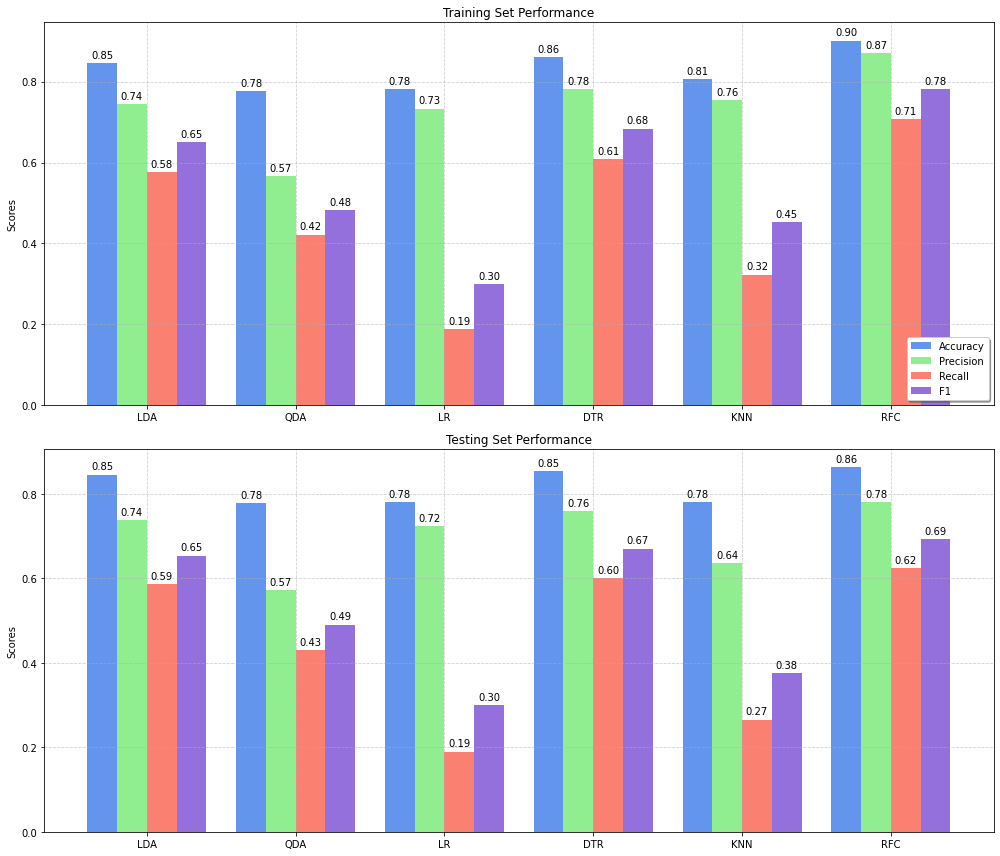

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_performance(metric_dict):
    labels = list(metric_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    train_scores = {metric: [metric_dict[model]['train'][metric] for model in labels] for metric in metrics}
    test_scores = {metric: [metric_dict[model]['test'][metric] for model in labels] for metric in metrics}

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, axs = plt.subplots(2, figsize=(14, 12))  # Create two subplots vertically

    # Colors for the bars
    colors = ['cornflowerblue', 'lightgreen', 'salmon', 'mediumpurple']

    # Plot for training set
    for i, metric in enumerate(metrics):
        bars = axs[0].bar(x + i*width, train_scores[metric], width, label=metric.capitalize(), color=colors[i])
        axs[0].bar_label(bars, padding=3, fmt='%.2f')
    axs[0].set_ylabel('Scores')
    axs[0].set_title('Training Set Performance')
    axs[0].set_xticks(x + width * 1.5)
    axs[0].set_xticklabels(labels)
    axs[0].legend(loc='lower right', shadow=True)
    axs[0].grid(True, linestyle='--', alpha=0.6)

    # Plot for testing set
    for i, metric in enumerate(metrics):
        bars = axs[1].bar(x + i*width, test_scores[metric], width, label=metric.capitalize(), color=colors[i])
        axs[1].bar_label(bars, padding=3, fmt='%.2f')
    axs[1].set_ylabel('Scores')
    axs[1].set_title('Testing Set Performance')
    axs[1].set_xticks(x + width * 1.5)
    axs[1].set_xticklabels(labels)
    # axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    # plt.savefig('plots/train_test_performance.png')
    plt.show()


plot_model_performance(metrics_results)


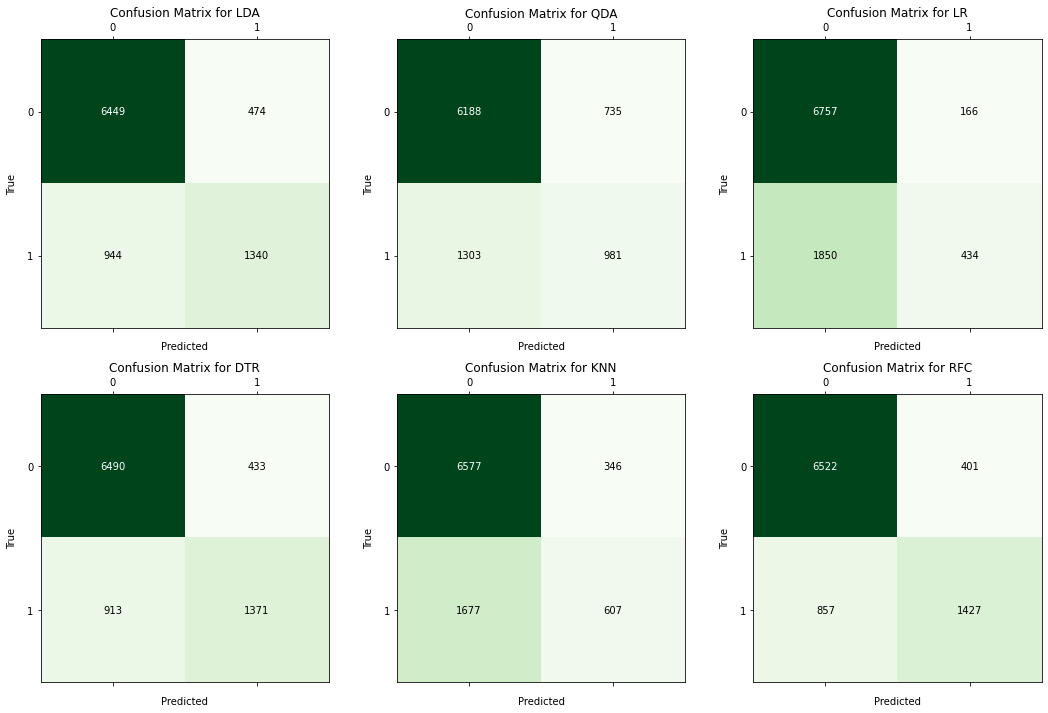

In [69]:
def plot_confusion_matrices(model_metrics):
    n_models = len(model_metrics)
    n_cols = 3
    n_rows = (n_models + 2) // n_cols  # Ensure enough rows are available
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten in case of multiple rows to ease indexing

    labels = ['0', '1']  # Generic labels for confusion matrix axes
    
    for ax, (model_name, metrics) in zip(axes, model_metrics.items()):
        # Convert metrics into confusion matrix format
        cm = np.array([[metrics['TN'], metrics['FP']], [metrics['FN'], metrics['TP']]])
        
        # Plot confusion matrix
        cax = ax.matshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
        # fig.colorbar(cax, ax=ax)
        ax.set_title(f'Confusion Matrix for {model_name}')
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.set_xlabel('Predicted', labelpad=10)
        ax.set_ylabel('True', labelpad=10)
        
        # Annotate confusion matrix with text
        thresh = np.max(cm) / 2.
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax.text(j, i, format(cm[i][j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i][j] > thresh else "black")

    # Hide any unused axes if the number of models is less than the number of subplots
    for i in range(len(model_metrics), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    # plt.savefig('plots/confusion_matrices.png')
    plt.show()

plot_confusion_matrices(cm_results)

In [123]:
from sklearn.model_selection import cross_val_score

features_ordered = [
    'relationship', 
    'marital-status',
    'age',
    'occupation',
    'education',      
    'hours-per-week',
    'sex',
    'workclass', 
    'race',
    'native-country',    
    'fnlwgt',
    'capital-loss',
    'capital-gain'
    ]

rfc_best_params = best_params_standard['RFC']
rfc_best_params = {k.replace('estimator__', ''): v for k, v in rfc_best_params.items()}

In [124]:
from tqdm import tqdm

def select_columns(data, prefixes):
    selected_columns = data.columns[data.columns.to_series().str.startswith(tuple(prefixes))]
    return data[selected_columns]

def incremental_feature_training(X_train, y_train, features_ordered, best_params):
    results = {}
    feature_set = []

    for feature in tqdm(features_ordered):
        feature_set.append(feature)
        estimator = RandomForestClassifier()
        pipeline = create_pipeline(estimator)
        results[len(feature_set)] = cross_val_score(pipeline, select_columns(X_train, feature_set), y_train, scoring='f1', cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2))
   
    return results


In [125]:
features_scores = incremental_feature_training(X_train, y_train, features_ordered, rfc_best_params)

100%|██████████| 13/13 [38:43<00:00, 178.72s/it]


In [126]:
features_scores

{1: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 2: array([0.        , 0.        , 0.        , 0.00218103, 0.00217865,
        0.00218103, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.0043573 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00217865, 0.        , 0.        , 0.        , 0.        ]),
 3: array([0.55042017, 0.48488372, 0.49448636, 0.53392659, 0.5149633 ,
        0.51094092, 0.55087128, 0.50452489, 0.54277929, 0.5       ,
        0.50491046, 0.5165851 , 0.53326063, 0.49401914, 0.49163301,
        0.51689189, 0.53260274, 0.54476397, 0.53151261, 0.53112948,
        0.53914002, 0.52086811, 0.52695942, 0.53969957, 0.51575013,
        0.51279136, 0.53192671, 0.52799122, 0.53581192, 0.53527194]),
 4: array([0.59035445, 0.57175793

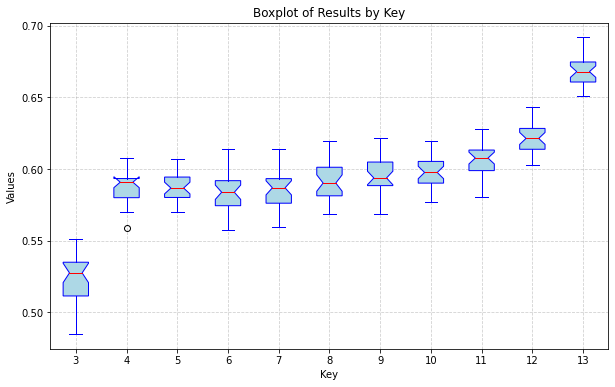

In [128]:
import matplotlib.pyplot as plt
def plot_results(data):
    plt.figure(figsize=(10, 6))
    
    # Extract the labels and values
    labels = list(data.keys())[2:]
    values = [data[key] for key in labels]

    # Create boxplots
    plt.boxplot(values, labels=labels, notch=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                medianprops=dict(color='red'))

    # Set title and labels
    plt.title('Boxplot of Results by Key')
    plt.xlabel('Key')
    plt.ylabel('Values')

    # Adding grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()
    

plot_results(features_scores)

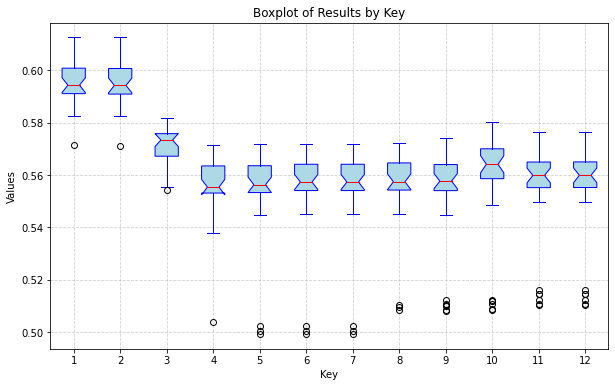

In [66]:
plot_results(features_scores_qda)

In [118]:
model = RandomForestClassifier(**rfc_best_params)

In [119]:
model.fit(select_columns(X_train, features_ordered), y_train)
# model.fit(X_train, y_train)
# select_columns(X_train, ['relationship', 'marital-status','occupation','education','age'])

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=300)

In [120]:
f1_score(model.predict(select_columns(X_test, features_ordered)), y_test)
# f1_score(model.predict(X_test), y_test)

0.6908294818778886

In [121]:
# f1_score(model.predict(X_train), y_train)
f1_score(model.predict(select_columns(X_train, features_ordered)), y_train)

0.7822468793342581

In [72]:
model.feature_importances_ 

array([1.21787782e-01, 7.23075988e-02, 1.28671306e-01, 3.97628059e-02,
       6.86617290e-02, 4.48423569e-03, 9.25086213e-03, 5.18267011e-03,
       8.31152980e-03, 3.42710581e-03, 2.25440503e-05, 4.17963328e-03,
       9.87741787e-04, 5.74085092e-04, 1.81080740e-03, 4.96862322e-03,
       3.44804857e-03, 3.29294097e-03, 3.71754803e-03, 2.70309795e-02,
       7.54504842e-03, 1.50714452e-02, 1.67057922e-02, 1.18558933e-04,
       9.73888258e-03, 8.31650197e-03, 4.41827981e-04, 1.48512754e-01,
       9.61038367e-04, 5.53306206e-02, 2.46063262e-03, 1.96886784e-03,
       1.04876025e-06, 5.66863845e-03, 2.66127592e-02, 5.45285536e-03,
       3.85654741e-03, 5.23194332e-03, 1.55698447e-02, 2.11946354e-04,
       2.61987249e-02, 2.70071492e-03, 6.54796387e-03, 4.68385217e-03,
       4.18613116e-03, 2.74499698e-02, 2.69668308e-03, 2.49337524e-02,
       1.52191150e-02, 2.70871963e-03, 4.33603755e-03, 5.43336349e-04,
       5.86100692e-03, 2.32031425e-02, 7.07271843e-03])

In [76]:
from sklearn.feature_selection import SelectFromModel

SelectFromModel(model, prefit=True).transform(X_train).shape

c:\Users\kaami\anaconda3\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(36826, 13)

In [78]:
model2 = RandomForestClassifier()
model2.fit(SelectFromModel(model, prefit=True).transform(X_train), y_train)
f1_score(model2.predict(SelectFromModel(model, prefit=True).transform(X_test)), y_test)

c:\Users\kaami\anaconda3\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.649058337161231